In [1]:
import numpy as np
import pandas as pd
import pyreadr
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from natsort import natsorted
from glob import glob
import pickle
import os
from os.path import basename, splitext
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import multivariate_normal
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
pd.set_option('display.max_columns', 40)
sns.set_theme(context='notebook', style='ticks')
plt.rcParams['axes.facecolor'] = '#fafafa'

from utils.shift import *
from utils.age import *
from utils.vis import plot_performance_scatter, plot_repr_uncertainty

%load_ext autoreload
%autoreload 2

#load published mouse clocks
clocks = pickle.load(open('subdata/clock_coefs_mouse.pkl', 'rb'))

# GSE120132 -> GSE60334 (Mouse embryogenesis)

In [31]:
#Aging (Thompson) https://www.aging-us.com/article/101590/text
# met = pickle.load(open('data/GSE120132/GSE120132_metlevs_processed_annotated.pkl', 'rb'))
# dfa = met.drop(['Strain', 'Tissue', 'Age', 'Sex', 'ID'], axis=1).T
# # dfa = dfa.dropna(0)
# meta = met[['Strain', 'Tissue', 'Sex', 'ID']].copy()
# meta['age'] = met['Age']
# dfa = dfa[meta.index]

#Aging (Thompson + Meer)
met = pickle.load(open('data/GSE120132_GSE121141/data.pkl', 'rb'))
dfa = met.drop(['Strain', 'Tissue', 'Age', 'Sex', 'GSE'], axis=1).T
meta = met[['Strain', 'Tissue', 'Sex', 'GSE']].copy()
meta['age'] = met['Age']
dfa = dfa[meta.index]

#Reprogramming + controls (Serrano)
dfr = pd.read_csv('data/GSE60334/data.csv', index_col=0)
metr = pd.read_csv('data/GSE60334/meta.csv', index_col=0)
#filtering & processing
metr = metr[metr['stage'] != 'Adult']
metr = metr[metr['condition'] == 'WT']
metr['age'] = [float(e.split('E')[1]) for e in metr['stage'].values]
dfr = dfr[metr.index]

# choose tissue from: ['Liver', None]
tissue_age = 'Blood'

if tissue_age is not None:
    meta = meta[meta['Tissue'] == tissue_age]
    dfa = dfa[meta.index].dropna(axis=0)

print('Age, N sites', len(dfa.index))
print('Rep, N sites', len(dfr.index))


# Thompson clock sites
clock = clocks['Thompson']

Age, N sites 934041
Rep, N sites 862533


## Select sites using best Lasso model for de-novo clocks

16849 common sites
R2 train = 0.9796540796317689
R2 test = 0.8660089196977163
MAE train = 3.5123067577232194
MAE test = 8.788712459375041
------------------------------


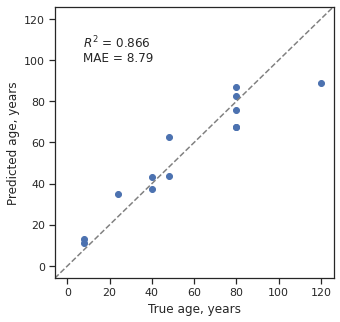

In [67]:
# #select de-novo sites
# sites = dfr.index.intersection(dfa.index)
# print(f"{len(sites)} common sites")

# Xa_clock = dfa.loc[sites].T
# Xr_clock = dfr.loc[sites].T

# ya = meta['age']
# yr = metr['age']

# X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)

# ### TRAINING ###
# from sklearn.linear_model import LassoCV
         
# model = LassoCV(n_jobs=-1)
# model.fit(X_train, y_train)

# y_train_predict = model.predict(X_train)
# y_test_predict = model.predict(X_test)

# print(f'R2 train = {r2_score(y_train, y_train_predict)}')
# print(f'R2 test = {r2_score(y_test, y_test_predict)}')
# print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
# print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
# print('-'*30)

# # write coefs
# lasso_sites = model.feature_names_in_[model.coef_ != 0]
# lasso_coef = model.coef_[model.coef_ != 0]
# clock = pd.DataFrame({'coef':lasso_coef}, index=lasso_sites)

# plot_performance_scatter(y_test, y_test_predict, eq_bounds=(0, 120))

In [141]:
# clock.index.intersection(dfr.index)

# idx = clock.index

# new_index = []
# for s in idx:
#     c, p = s.split('_')
#     new_index.append(c + '_' + str(int(p)))

# len(dfr.index.intersection(new_index)  )

In [134]:

# filt = ['Fibroblast', 'Transient reprogramming intermediate', 'iPSC']
# cond = metr['Condition'].isin(filt)

# metr = metr[cond]
# dfr = dfr.loc[:, cond]
# methclock = methclock[cond].dropna(axis=1)
# print(metr['Condition'].unique())

# groupr = methclock.groupby('age').mean()

# repday0 = 0
# repday1 = 17

## Check covariate shift

In [33]:
sites = clock.index.intersection(dfr.index).intersection(dfa.index)
print(f"{len(sites)} common sites")

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

ya = meta['age']
yr = metr['age']

#conduct PCA on joined dataset
pca = PCA(2)
pca.fit(pd.concat([Xa_clock, Xr_clock]))
Xpa = pca.transform(Xa_clock)
Xpr = pca.transform(Xr_clock)

pvar = np.round(pca.explained_variance_ratio_, 2)

348 common sites


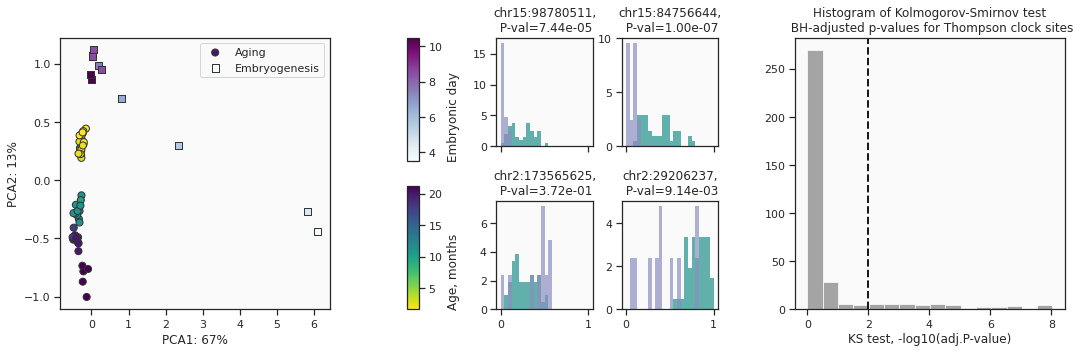

In [35]:
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

fig = plt.figure(figsize=(18, 5), constrained_layout=True)
gs = GridSpec(2, 7, figure=fig, width_ratios=[4, 4, 0.5, 3, 3, 4, 4], wspace=1.0, hspace=0.5) 

axcbrs = gs[:, 2].subgridspec(2, 1)
axcb1, axcb2 = axcbrs.subplots()

minihists = gs[:, 3:5].subgridspec(2, 2, wspace=0.3, hspace=0.5)
minihist_subs = minihists.subplots(sharex=True)
ax0 = fig.add_subplot(gs[:, :2])
ax1 = minihist_subs[0,0]
ax2 = minihist_subs[0,1]
ax3 = minihist_subs[1,0]
ax4 = minihist_subs[1,1]
ax5 = fig.add_subplot(gs[:, 5:])

#cbars
cmap_age = mpl.cm.viridis_r
cmap_rep = mpl.cm.BuPu
norm_age = mpl.colors.Normalize(vmin=min(ya), vmax=max(ya))
norm_rep = mpl.colors.Normalize(vmin=min(yr), vmax=max(yr))
cb_age = mpl.colorbar.ColorbarBase(axcb2, cmap=cmap_age, norm=norm_age)
cb_rep = mpl.colorbar.ColorbarBase(axcb1, cmap=cmap_rep, norm=norm_rep)
cb_age.set_label('Age, months', loc='bottom')
cb_rep.set_label('Embryonic day', loc='bottom')

# ax0 - PCA
ax0.set_title('')
z1_plot = ax0.scatter(Xpa[:, 0], Xpa[:, 1], c=ya, s=50, label='Aging', 
                      edgecolors='#333333', cmap=cmap_age)
z2_plot = ax0.scatter(Xpr[:, 0], Xpr[:, 1], c=yr, marker='s', s=50, label='Embryogenesis', 
                      edgecolors='#333333', cmap=cmap_rep)
ax0.set_xlabel(f'PCA1: {int(pvar[0]*100)}%')
ax0.set_ylabel(f'PCA2: {int(pvar[1]*100)}%')
ax0.legend()

# ax5 - overall KS pvalues hist
ks, ksp = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='ks')
kspa = multipletests(ksp, method='hs')[1]
kspa = pd.DataFrame(index=Xa_clock.columns, data={'pval':kspa})
kspaval = -np.log10(kspa['pval'].values)
kspaval = np.where(kspaval < 20, kspaval , 20)
ax5.set_title('Histogram of Kolmogorov-Smirnov test\n BH-adjusted p-values for Thompson clock sites')
ax5.hist(kspaval, density=False, alpha=0.7, color='grey', bins=16)
ax5.axvline(-np.log10(0.01), color='k', ls='--', lw=2.0)
ax5.set_xlabel('KS test, -log10(adj.P-value)')
# ax5.set_xlim(0, 20)

#top sites from Skin clock based on correlation with age
selected_sites = Xa_clock.corrwith(ya).abs().sort_values(ascending=False).index[:4]

#examples of sites + PSIs
for k, ax_ in enumerate([ax1, ax2, ax3, ax4]): 
    site_pval = kspa.loc[selected_sites[k], 'pval']
    ax_.hist(Xa_clock[selected_sites[k]], density=True, alpha=0.7, 
             color='#20918c', 
             bins=np.linspace(0, 1, 25), 
             edgecolor='none')
    ax_.hist(Xr_clock[selected_sites[k]], density=True, alpha=0.7, 
             color='#8c8ec1', 
             bins=np.linspace(0, 1, 25), 
             edgecolor='none')
    ax_.set_title(f'{selected_sites[k].replace("_", ":")},\n P-val={"{0:.2e}".format(site_pval)}')
    ax_.set_xlim([-0.05, 1.05])

plt.savefig('figs/A1_main_embryo.pdf', format='pdf', bbox_inches='tight')
plt.show()


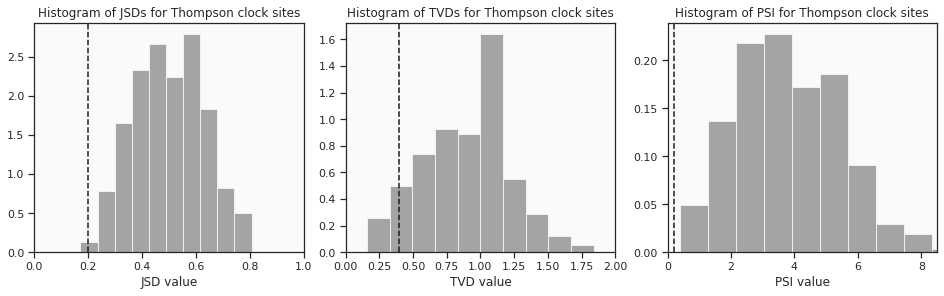

In [36]:
#supplement

fig = plt.figure(figsize=(13, 4), constrained_layout=True)
gs = GridSpec(1, 3, figure=fig) 
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

# ax5 - overall PSI hist
jsds = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='jsd')

ax0.set_title('Histogram of JSDs for Thompson clock sites')
ax0.hist(jsds, density=True, alpha=0.7, color='grey')
ax0.axvline(0.2, color='k', ls='--')
ax0.set_xlim([0, 1])
ax0.set_xlabel('JSD value')

tvds = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='tvd')

ax1.set_title('Histogram of TVDs for Thompson clock sites')
ax1.hist(tvds, density=True, alpha=0.7, color='grey')
ax1.axvline(0.4, color='k', ls='--')
ax1.set_xlim([0, 2])
ax1.set_xlabel('TVD value')

psis = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='psi')

ax2.set_title('Histogram of PSI for Thompson clock sites')
ax2.hist(psis, density=True, alpha=0.7, color='grey')
ax2.axvline(0.2, color='k', ls='--')
ax2.set_xlim([0, 8.5])
ax2.set_xlabel('PSI value')

plt.savefig('figs/A1_sup_embryo_metrics.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Inversed Train Test Procedure (ITTP)

In [37]:
# case with dim X > 1
sites = clock.index.intersection(dfr.index).intersection(dfa.index)
print(f"{len(sites)} common sites")

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

ya = meta['age']
yr = metr['age']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)

348 common sites


Step 1 results:
R2 train = 0.988
MAE train = 0.641
R2 test = 0.909
MAE test = 2.001
------------------------------
Step 2 results:
R2 train = 0.9
MAE train = 2.179
R2 test = 0.841
MAE test = 2.285
------------------------------


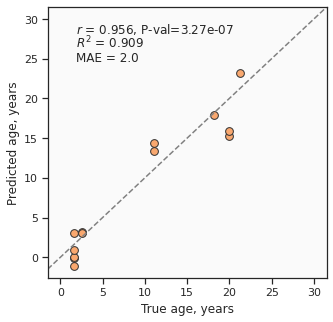

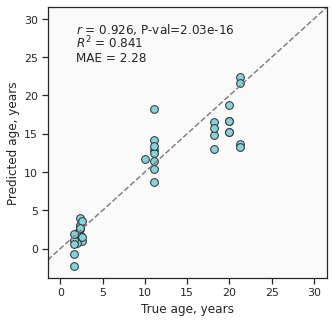

In [38]:
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.linear_model import LassoCV
(y_train_predict_step1, 
 y_test_predict_step1, 
 y_train_predict_step2,
 y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 X_train, y_train, 
                                 X_test, y_test=y_test, 
                                 params={"max_iter":3000},
                                 verbose=0)

plot_performance_scatter(y_test, y_test_predict_step1, eq_bounds=(0, 30), color='#f9a86f', markersize=60)
plt.savefig('figs/A3_aging_blood_train_test_step1.pdf', format='pdf', bbox_inches='tight')
plt.show()

plot_performance_scatter(y_train, y_test_predict_step2, eq_bounds=(0, 30), color='#86d2da', markersize=60)
plt.savefig('figs/A3_aging_blood_train_test_step2.pdf', format='pdf', bbox_inches='tight')
plt.show()

Step 1 results:
R2 train = 0.999
MAE train = 0.152
------------------------------
Step 2 results:
R2 test = -4.915
MAE test = 17.411
------------------------------


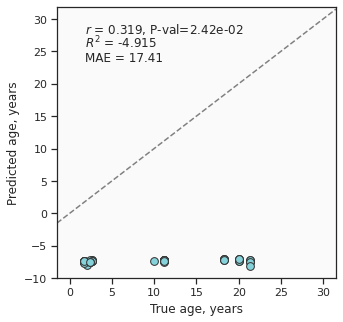

In [39]:
(y_train_predict_step1, 
y_test_predict_step1, 
y_train_predict_step2,
y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 Xa_clock, ya, 
                                 Xr_clock, y_test=None, 
                                 params={"max_iter":3000},
                                 verbose=1)

plot_performance_scatter(ya, y_test_predict_step2, eq_bounds=(0, 30), color='#86d2da', markersize=60)
plt.savefig('figs/A3_aging_blood_train_embryo_test_step2.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Epistemic uncertainty estimation with Gaussian Process Regressor

348 common sites
R2 train = 0.9999760566466798
R2 test = 0.9356960697309668
MAE train = 0.030153897778901623
MAE test = 1.732961402023839
------------------------------
Resulting kernel: 16.2**2 * RBF(length_scale=3.99) + WhiteKernel(noise_level=0.1)
Resulting kernel (full): 11.6**2 * RBF(length_scale=2.81) + WhiteKernel(noise_level=0.1)


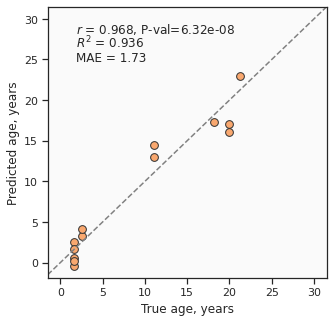

In [40]:
sites = clock.index.intersection(dfr.index).intersection(dfa.index)
print(f"{len(sites)} common sites")

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

ya = meta['age'] 
yr = metr['age']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)

### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

# kernel = 1 * DotProduct(sigma_0=1, sigma_0_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(0, 30), color='#f9a86f', markersize=60)
plt.savefig('figs/A4_sup_GP_blood_test_performance.pdf', format='pdf', bbox_inches='tight')

model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(Xa_clock, ya)
print("Resulting kernel (full):", model.kernel_)

Avg uncertainty std: 5.7232093995217195
P-value of rejuvenation effect between 3.5 and 8.5 days is 0.5436804989351152
P-value of rejuvenation effect between 8.5 and 10.5 days is 0.37603291384412263


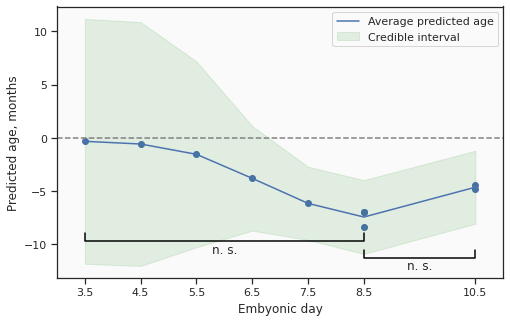

In [52]:
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

plot_repr_uncertainty(yr.values, y_test_predict_r, y_test_std_r, 
                      days=[(3.5, 8.5), (8.5, 10.5)],
                      nstd=1, dh=[0.06, 0.12], barh=0.03,
                      ylabel='Predicted age, months',
                      xlabel='Embyonic day'
                      )

plt.savefig('figs/A4_embryo_trajectory.pdf', format='pdf', bbox_inches='tight')

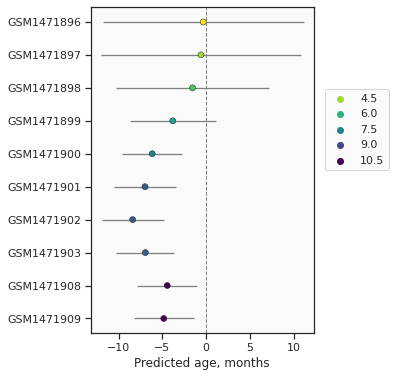

R2 test = -30.486567595110873
MAE test = 11.793438962504109


In [55]:
import matplotlib as mpl
import matplotlib.cm as cm

#prediction of test dataset
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

metr['gpr_age'] = y_test_predict_r
metr['gpr_std'] = y_test_std_r
   
fig, ax = plt.subplots(1,1, figsize=(4, 6))
metr_ = metr.copy().reset_index().sort_values('age')


ax.errorbar(x=metr_['gpr_age'], y=metr_['index'], xerr=metr_['gpr_std'], linewidth=0, elinewidth=1.3, color='grey')

sns.scatterplot(
    data=metr_, x="gpr_age", y='index',  
    marker="o",
    hue='age',
    edgecolor='k',
    palette=mpl.cm.viridis_r,
    zorder=2,
    ax=ax
)

ax.axvline(0, ls='--', lw=1, color='grey')
ax.set_xlabel('Predicted age, months')
ax.set_ylabel('')
ax.legend(loc=[1.05, 0.5])
plt.show()

print(f'R2 test = {r2_score(yr, y_test_predict_r)}')
print(f'MAE test = {mean_absolute_error(yr, y_test_predict_r)}')